<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Итоговая-таблица-сравнения-моделей-для-решения-поставленной-задачи" data-toc-modified-id="Итоговая-таблица-сравнения-моделей-для-решения-поставленной-задачи-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span><em>Итоговая таблица сравнения моделей для решения поставленной задачи</em></a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span><em>Проверка модели на адекватность</em></a></span></li></ul></li><li><span><a href="#Общий-вывод-по-исследованию" data-toc-modified-id="Общий-вывод-по-исследованию-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод по исследованию</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [27]:
# импорт необходимых библиотек
import os.path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [28]:
def camel_to_snake(s):
    return ''.join(['_' + c.lower() if c.isupper() else c for c in s]).lstrip('_')


def convert_columns_to_snake_case(data):
    data.columns = map(camel_to_snake, data.columns)
    return np.array(data.columns)


def full_duplicates(data):
    count_full_duplicates = data.duplicated().sum()
    data.drop_duplicates(inplace=True)
    print(f'Число обнаруженных и удаленных полных дубликатов: {count_full_duplicates}')


def implicit_duplicates(data):
    ocols = data.select_dtypes('object').columns
    data[ocols] = data[ocols].apply(lambda x: x.str.lower())
    for col in data[ocols]:
        print(f"{col}: {np.array(data[col].sort_values().unique())}", end='\n\n')


def type_changes(data):
    fcols = data.select_dtypes('float').columns
    icols = data.select_dtypes('integer').columns
    data[fcols] = data[fcols].apply(pd.to_numeric, downcast='float')
    data[icols] = data[icols].apply(pd.to_numeric, downcast='integer')
    return data.info()


def pass_percentage(data):
    return pd.DataFrame(round(data.isna().mean() * 100)) \
        .rename(columns={0: 'space'}).query('space > 0') \
        .sort_values(by='space', ascending=True) \
        .style.background_gradient('coolwarm')


def anomaly_research(data):
    return data.describe(percentiles=[0.0012, 0.01, .5, .99, .9988]).drop(['count', 'mean', 'std'], axis=0)


def replace_zeroes_values(data, list):
    data[list] = data[list].replace(0, np.nan)
    return data.describe(percentiles=[0.0012, 0.01, .5, .99, .9988]).drop(['count', 'mean', 'std'], axis=0)


def check_features(data, columns):
    list_0012, list_01, list_99, list_9988 = [], [], [], []
    for col in columns:
        min_val = data[col].min()
        quantile_0012 = data[col].quantile(0.0012)
        quantile_01 = data[col].quantile(0.01)
        max_val = data[col].max()
        quantile_9988 = data[col].quantile(0.9988)
        quantile_99 = data[col].quantile(0.99)
        if abs(quantile_0012) < abs(quantile_01) / 3:
            list_01.append(col)
        elif abs(min_val) < abs(quantile_0012) / 3:
            list_0012.append(col)

        if abs(quantile_99) < abs(quantile_9988) / 3:
            list_99.append(col)
        elif abs(max_val) / 3 > abs(quantile_9988):
            list_9988.append(col)
    return list_0012, list_01, list_99, list_9988


def correct_features(data, columns):
    list_0012, list_01, list_99, list_9988 = check_features(data, columns)

    for col in list_0012:
        q = data[col].quantile(0.0012)
        data = data.loc[data[col] >= q, columns]

    for col in list_01:
        q = data[col].quantile(0.01)
        data = data.loc[data[col] >= q, columns]

    for col in list_99:
        q = data[col].quantile(0.99)
        data = data.loc[data[col] <= q, columns]

    for col in list_9988:
        q = data[col].quantile(0.9988)
        data = data.loc[data[col] <= q, columns]
    return data

In [29]:
try:
    if os.path.isfile('datasets/taxi.csv'):
        df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
    else:
        df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [30]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим наличие пропусков.

In [31]:
pass_percentage(df)

,space


Пропущенные значения отсутствуют. Произведем ресемплирование данных по одному часу.

In [32]:
df = df.sort_index().resample('1H').sum()

## Анализ

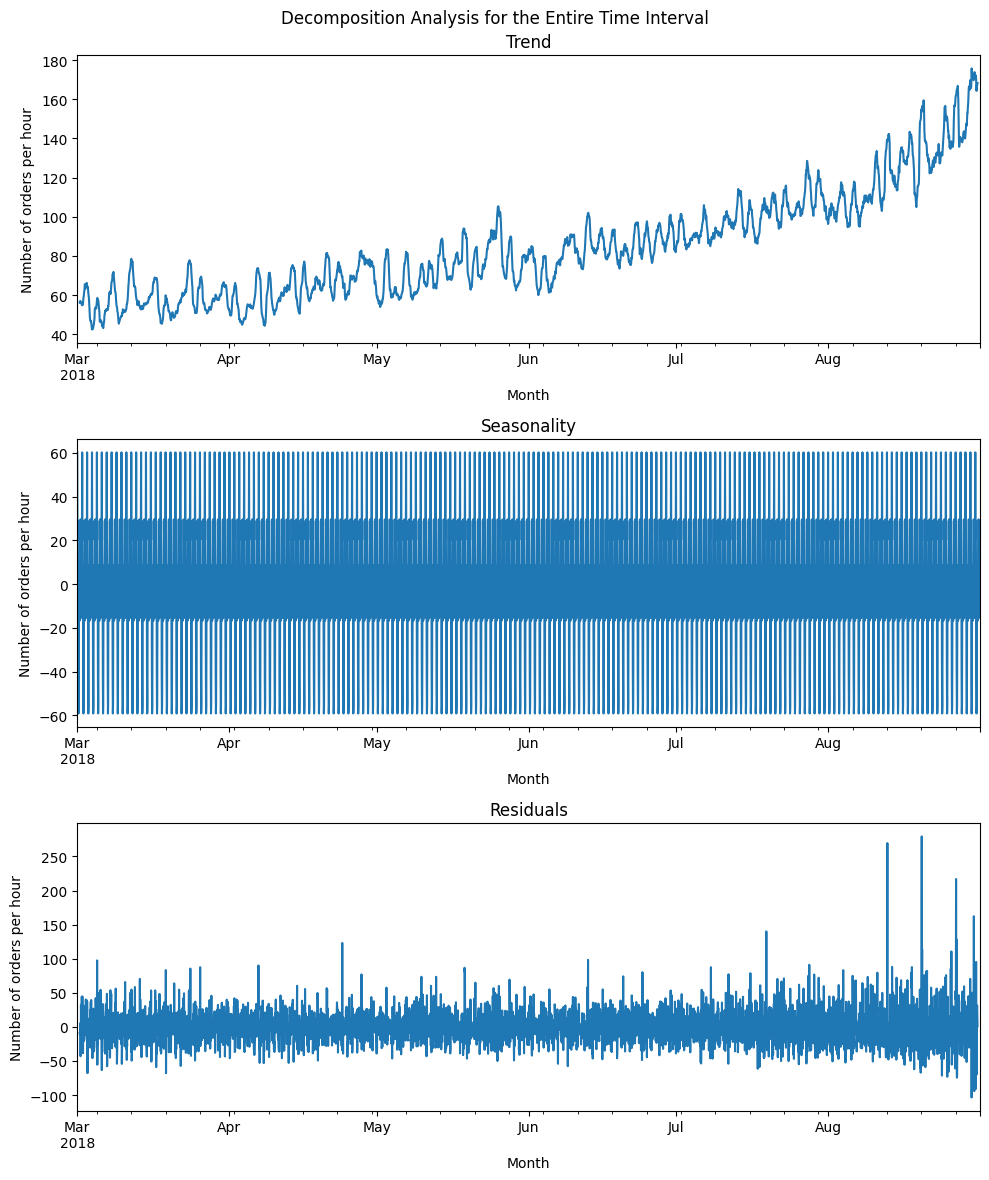

In [33]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(10, 12))
plt.suptitle('Decomposition Analysis for the Entire Time Interval')

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Number of orders per hour')
plt.xlabel('Month')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Number of orders per hour')
plt.xlabel('Month')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Number of orders per hour')
plt.xlabel('Month')

plt.tight_layout()

Проанализировав наш исходный df мы можем сделать вывод, что мы имеем восходящий тренд, а также увеличивающая дисперсия в шумах к концу августа месяца.

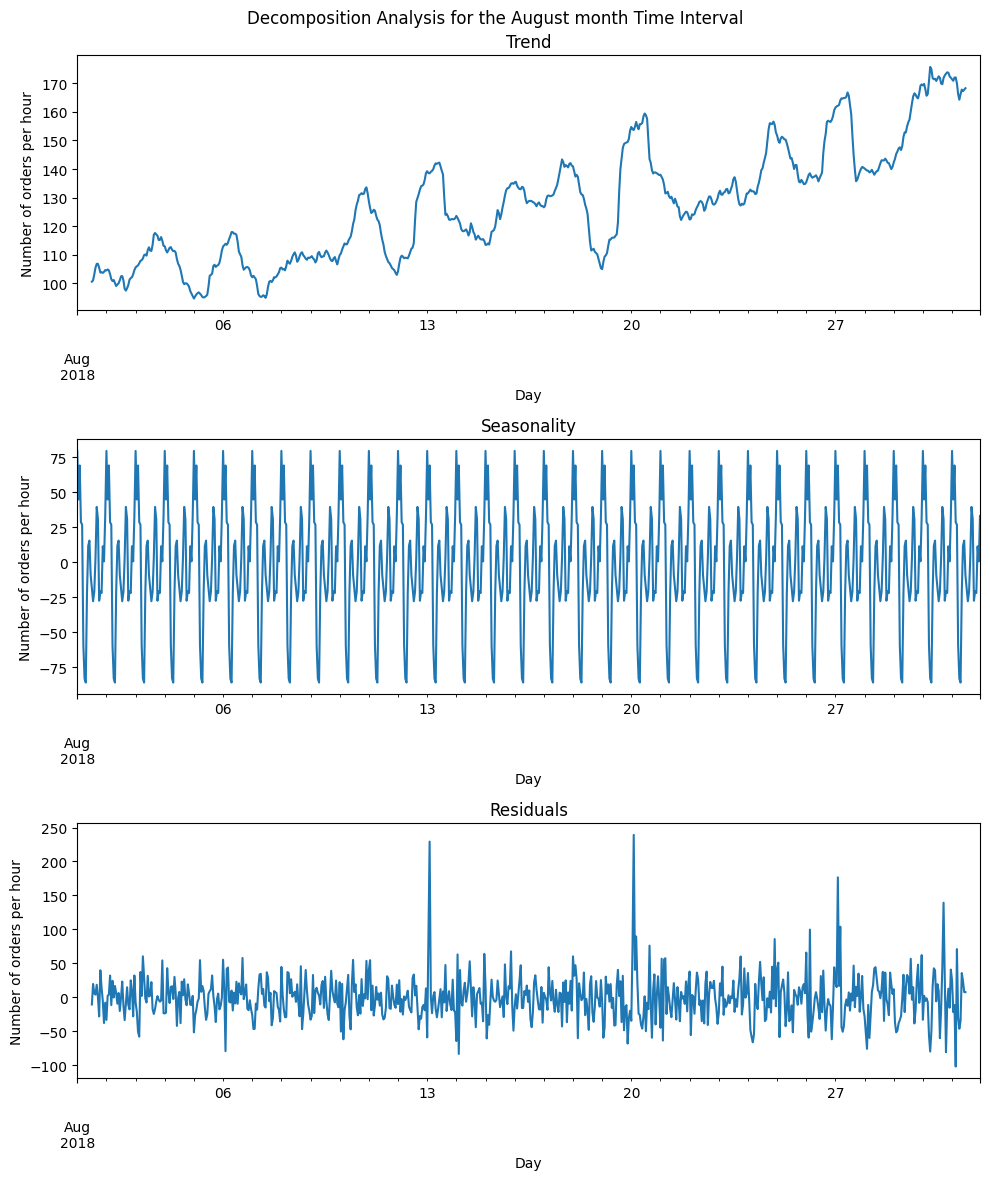

In [34]:
decomposed = seasonal_decompose(df['2018-08': '2018-09'])

plt.figure(figsize=(10, 12))
plt.suptitle('Decomposition Analysis for the August month Time Interval')

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Number of orders per hour')
plt.xlabel('Day')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Number of orders per hour')
plt.xlabel('Day')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Number of orders per hour')
plt.xlabel('Day')

plt.tight_layout()

Анализируя в разрезе одного месяца - августа, мы также наблюдаем восходящий тренд, заметна четкая сезонность по дням недели и наличие выраженных шумов с середины и до конца месяца.

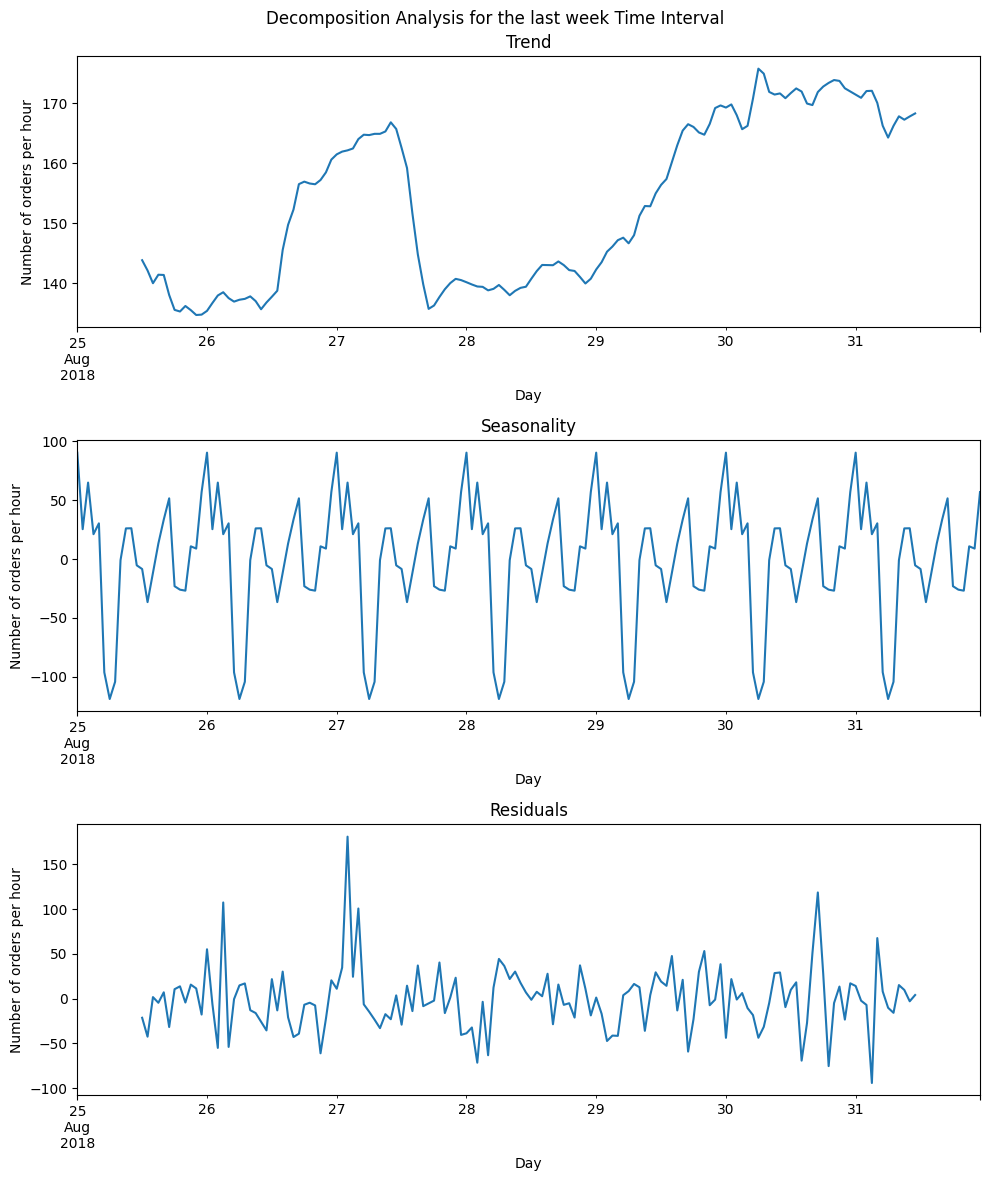

In [35]:
decomposed = seasonal_decompose(df['2018-08-25': '2018-09'])

plt.figure(figsize=(10, 12))
plt.suptitle('Decomposition Analysis for the last week Time Interval')

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Number of orders per hour')
plt.xlabel('Day')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Number of orders per hour')
plt.xlabel('Day')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Number of orders per hour')
plt.xlabel('Day')

plt.tight_layout()

Анализируя последнюю доступную неделю мы видим еще раз в более близком приближении сезонность по дням недели и продолжение восходящего тренда.

## Обучение

Создадим признаки, необходимые для прогнозирования временного ряда используя функцию. И произведем разделение df на тренировочную и тестовую выборки в соотношении 9 к 1.

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 168, 56)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train, features_test = train.drop('num_orders', axis=1), test.drop('num_orders', axis=1)
target_train, target_test = train['num_orders'], test['num_orders']

Проведем кросс-валидационные тесты и выберем модель с наилучшей предсказательной способностью по заданной метрике RMSE.

In [11]:
linear_model = cross_val_score(LinearRegression(), features_train, target_train,
                               cv=TimeSeriesSplit(n_splits=5), n_jobs=-1,
                               scoring='neg_root_mean_squared_error')
res_linear = -linear_model.mean()

In [12]:
# model = Lasso()
# params = {'alpha': list(np.arange(0.01, 1, 0.01)),
#           'selection': ['cyclic', 'random'],
#           'random_state': [42]
#           }
# Lasso_model = RandomizedSearchCV(model, param_distributions=params, random_state=42, cv=TimeSeriesSplit(n_splits=5), n_jobs=-1,
#                                  scoring='neg_root_mean_squared_error').fit(features_train, target_train)
# res_lasso = -Lasso_model.best_score_

In [13]:
best_params_lasso = {'selection': 'random', 'random_state': 42, 'alpha': 0.84}
forest_model = cross_val_score(Lasso(**best_params_lasso), features_train, target_train,
                               cv=TimeSeriesSplit(n_splits=5),
                               n_jobs=-1, scoring='neg_root_mean_squared_error')
res_lasso = -forest_model.mean()

In [14]:
# model = Ridge()
# params = {'alpha': list(np.arange(0.01, 500, 0.01)),
#           'random_state': [42]
#           }
# Ridge_model = RandomizedSearchCV(model, param_distributions=params, cv=TimeSeriesSplit(n_splits=5), n_jobs=-1,
#                                  scoring='neg_root_mean_squared_error').fit(features_train, target_train)
# res_ridge = -Ridge_model.best_score_

In [15]:
best_params_ridge = {'random_state': 42, 'alpha': 24.93}
forest_model = cross_val_score(Ridge(**best_params_ridge), features_train, target_train,
                               cv=TimeSeriesSplit(n_splits=5),
                               n_jobs=-1, scoring='neg_root_mean_squared_error')
res_ridge = -forest_model.mean()

In [16]:
# model = RandomForestRegressor()
# params = {
#     'n_estimators': [100, 200],
#     'min_samples_leaf': list(range(1, 8)),
#     'min_samples_split': list(range(2, 8)),
#     'max_depth': list(range(4, 21, 2)),
#     'random_state': [42]
# }
# forest_model = RandomizedSearchCV(model, param_distributions=params, cv=TimeSeriesSplit(n_splits=5), n_jobs=-1,
#                                   scoring='neg_root_mean_squared_error').fit(features_train, target_train)
# -forest_model.best_score_

In [17]:
best_params_forest = {'random_state': 42,
                      'n_estimators': 100,
                      'min_samples_split': 2,
                      'min_samples_leaf': 4,
                      'max_depth': 10}
forest_model = cross_val_score(RandomForestRegressor(**best_params_forest), features_train, target_train,
                               cv=TimeSeriesSplit(n_splits=5),
                               n_jobs=-1, scoring='neg_root_mean_squared_error')
res_forest = -forest_model.mean()

In [18]:
# model = CatBoostRegressor(logging_level='Silent')
# params = {
#     'n_estimators': [500],
#     'learning_rate': list(np.arange(0.1, 0.5, 0.01)),
#     'max_depth': list(range(7, 15, 1)),
#     'min_child_samples': list(range(4, 12)),
#     'num_leaves': [31, 62, 124],
#     'random_state': [42]
# }
#
# catboost_model = RandomizedSearchCV(model, param_distributions=params, cv=TimeSeriesSplit(n_splits=5), n_jobs=-1,
#                                     scoring='neg_root_mean_squared_error').fit(features_train, target_train)
# -catboost_model.best_score_

In [19]:
cat_b_best_p = {'random_state': 42,
                'num_leaves': 31,
                'n_estimators': 500,
                'min_child_samples': 7,
                'max_depth': 8,
                'learning_rate': 0.17}
cat_model = cross_val_score(CatBoostRegressor(logging_level='Silent'), features_train, target_train,
                            cv=TimeSeriesSplit(n_splits=5), n_jobs=-1,
                            scoring='neg_root_mean_squared_error')
res_cat = -cat_model.mean()

In [20]:
# model = LGBMRegressor()
# params = {
#     'n_estimators': [500],
#     'learning_rate': list(np.arange(0.1, 0.5, 0.01)),
#     'max_depth': list(range(7, 15, 1)),
#     'min_child_samples': list(range(4, 12)),
#     'num_leaves': [124],
#     'random_state': [42]
# }
#
# LGBM_model = RandomizedSearchCV(model, param_distributions=params, cv=TimeSeriesSplit(n_splits=5), n_jobs=-1,
#                                 scoring='neg_root_mean_squared_error').fit(features_train, target_train)
# -LGBM_model.best_score_

In [21]:
LGBM_model_best_p = {'random_state': 42,
                     'num_leaves': 124,
                     'n_estimators': 500,
                     'min_child_samples': 9,
                     'max_depth': 8,
                     'learning_rate': 0.13}

LGBM_model = cross_val_score(LGBMRegressor(**LGBM_model_best_p), features_train, target_train,
                             cv=TimeSeriesSplit(n_splits=5), n_jobs=-1,
                             scoring='neg_root_mean_squared_error')
res_lgbm = -LGBM_model.mean()

---
### *Итоговая таблица сравнения моделей для решения поставленной задачи*

In [22]:
res_table = pd.DataFrame({'rmse': [round(res_linear, 2), round(res_lasso, 2), round(res_ridge, 2), round(res_forest, 2),
                                   round(res_cat, 2), round(res_lgbm, 2)]},
                         index=['LinearRegression', 'LassoRegression', 'RidgeRegression', 'RandomForestRegressor',
                                'CatBoostRegressor', 'LGBMRegressor'])
res_table.sort_values(by='rmse')

,rmse
LassoRegression,22.39
LinearRegression,22.54
RidgeRegression,22.54
CatBoostRegressor,22.59
RandomForestRegressor,22.78
LGBMRegressor,23.66


На основании кросс-валидационных тестов лучшей моделью по выбранной метрике RMSE на тренировочных данных можем считать LassoRegression.

In [23]:
lasso_model = Lasso(**best_params_lasso).fit(features_train, target_train)

## Тестирование

In [24]:
predict = lasso_model.predict(features_test)
print(
    f'Итоговый показатель RMSE для выбранной модели на тестовой выборке:'
    f' {mean_squared_error(target_test, predict, squared=False):.2f}')

Итоговый показатель RMSE для выбранной модели на тестовой выборке: 34.51


---
### *Проверка модели на адекватность*

Создадим dummy модели, которые предсказывают все целые значения a) предыдущим значением b) средним значением по тестовой выборке и выведем результат нашей целевой метрики.
Далее сравним это значение с получившимся значением на тестовой выборке.

In [25]:
previous_value_dummy_checker = target_test.shift(fill_value=features_test.iloc[-1][0])
mean_squared_error(target_test, previous_value_dummy_checker, squared=False)

58.94774893134087

In [26]:
mean_value_dummy_checker = np.array([target_test.mean()] * target_test.shape[0])
mean_squared_error(target_test, mean_value_dummy_checker, squared=False)

58.549609354757315

Модель успешно прошла проверку на адекватность.

---
## Общий вывод по исследованию

<div style="border:solid orange 2px; padding: 5px">

<div class="alert alert-info"> <b>При проведении исследования (на основе полученных данных) выполнено:</b></div>

- Проведено ресемплирование данных по одному часу.
- Произведен графический анализ временного ряда, разложенного на тренд, сезонность и шум на различных временных интервалах.
    - Проанализировав весь df мы можем сделать вывод, что мы имеем восходящий тренд, а также увеличивающая дисперсия в шумах к концу августа месяца.
    - Анализируя данные в разрезе одного месяца: августа, мы также наблюдаем восходящий тренд, заметна четкая сезонность по дням недели и наличие выраженных шумов с середины и до конца месяца.
    - Анализируя последнюю доступную неделю мы видим еще раз в более близком приближении сезонность по дням недели и продолжение восходящего тренда.

- Созданы дополнительные признаки, необходимые для прогнозирования временного ряда.
- Проведены кросс-валидационные тесты на тренировочной выборке и выбрана модель с наилучшей предсказательной способностью по заданной метрике RMSE - LassoRegressor с показателем 22.39.
- Проведено тестирование выбранной модели на тестовой выборке, получен показатель RMSE - 34.51.
- Проведена проверка на адекватность, включающая в себе проверку на двух dummy-моделях, одна из которых построена на прогнозировании с помощью предыдущего значения, а вторая с использованием среднего значения тестовой выборки. Выбранная нами модель успешно прошла проверку на адекватность.